<img src="https://5264302.fs1.hubspotusercontent-na1.net/hubfs/5264302/Demo%20Asset%20Resources/CM-Demo-mdf-stablecoins-Cover.png" width=1100 margin-left='auto' margin-right='auto'/>


Since Tether's launch in 2014, stablecoins have grown to become one of the most dominant sectors in the world of digital assets. Many considered them to be crypto's "killer app," providing global access to stable savings and payment rails beyond the rigid confines of the traditional banking system. In this walkthrough, we use Coin Metrics **Market Data Feed** and **CM Prices** to explore the various venues where these assets are traded, and examine various pricing methodologies that allow us to better understand how they perform in comparison to the underlying fiat currencies.

## Resources

This notebook demonstrates basic functionality offered by the Coin Metrics Python API Client and Market Data Feed.

Coin Metrics offers a vast assortment of data for hundreds of cryptoassets. The Python API Client allows for easy access to this data using Python without needing to create your own wrappers using `requests` and other such libraries.

To understand the data that Coin Metrics offers, feel free to peruse the resources below.

- The [Coin Metrics API v4](https://docs.coinmetrics.io/api/v4) website contains the full set of endpoints and data offered by Coin Metrics.
- The [Coin Metrics Knowledge Base](https://docs.coinmetrics.io/info) gives detailed, conceptual explanations of the data that Coin Metrics offers.
- The [API Spec](https://coinmetrics.github.io/api-client-python/site/api_client.html) contains a full list of functions.

## Notebook Setup

In [1]:
from os import environ
import sys
import pandas as pd
import seaborn as sns
import logging
from datetime import date, datetime, timedelta
from coinmetrics.api_client import CoinMetricsClient
import json
import logging
from pytz import timezone as timezone_conv
from datetime import timezone as timezone_info
import matplotlib
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter, YearLocator, AutoDateLocator
from matplotlib.ticker import NullFormatter
import matplotlib.pyplot as plt
import plotly.express as px 
import numpy as np
%matplotlib inline

In [2]:
sns.set_theme()
plt.rcParams.update({'font.size': 16, 'font.family': 'arial'})
sns.set(rc={'figure.figsize':(14,8)})

In [3]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [4]:
# We recommend privately storing your API key in your local environment.
try:
    api_key = environ["CM_API_KEY"]
    logging.info("Using API key found in environment")
except KeyError:
    api_key = ""
    logging.info("API key not found. Using community client")
    
client = CoinMetricsClient(api_key)

2024-10-03 11:41:34 INFO     Using API key found in environment


# Get Stablecoin Markets

The catalog/markets endpoint returns a list of available markets along with time ranges of available data. Users can pass in a list of markets, exchanges, or market types (spot, futures, options). We can retrieve our stablecoin markets by fetching a list of all 'spot' markets, then filtering for the markets where the 'base' or 'quote' parameter is equivalent to our stablecoin of interest.

In [5]:
ticker = 'usdt'

stablecoin_markets = client.reference_data_markets(
    type='spot',
    asset=ticker,
    page_size=10000
).to_dataframe()[['market','exchange','base','quote','symbol']]

In [6]:
client.reference_data_markets(
    type='spot',
    asset=ticker,
    page_size=10000
).to_dataframe().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19949 entries, 0 to 19948
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   market                  19949 non-null  string 
 1   exchange                19949 non-null  string 
 2   base                    19949 non-null  string 
 3   quote                   19949 non-null  string 
 4   pair                    19949 non-null  string 
 5   symbol                  19808 non-null  string 
 6   type                    19949 non-null  string 
 7   size_asset              0 non-null      Int64  
 8   margin_asset            0 non-null      Int64  
 9   strike                  0 non-null      Int64  
 10  option_contract_type    0 non-null      Int64  
 11  is_european             0 non-null      Int64  
 12  contract_size           0 non-null      Int64  
 13  tick_size               0 non-null      Int64  
 14  multiplier_size         0 non-null    

In [7]:
# ticker = 'usdt'
# stablecoin_markets = spot_markets.loc[(spot_markets['base']==ticker) | (spot_markets['quote']==ticker)]

In [8]:
# stablecoin_markets[['market','min_time','max_time','exchange','base','quote','symbol']]

In [9]:
stablecoin_markets

,market,exchange,base,quote,symbol
0,bibox-1inch-usdt-spot,bibox,1inch,usdt,1INCH_USDT
1,bibox-aaa-usdt-spot,bibox,aaa,usdt,AAA_USDT
2,bibox-aave-usdt-spot,bibox,aave,usdt,AAVE_USDT
3,bibox-ac-usdt-spot,bibox,ac,usdt,AC_USDT
4,bibox-acmd-usdt-spot,bibox,acmd,usdt,ACMD_USDT
...,...,...,...,...,...
19944,zb.com-yfii-usdt-spot,zb.com,yfii,usdt,yfii_usdt
19945,zb.com-ygg-usdt-spot,zb.com,ygg,usdt,ygg_usdt
19946,zb.com-zb-usdt-spot,zb.com,zb,usdt,zb_usdt
19947,zb.com-zkn-usdt-spot,zb.com,zkn,usdt,zkn_usdt


In [10]:
markets_by_exchange = pd.DataFrame(stablecoin_markets['exchange'].value_counts()).reset_index()
markets_by_exchange['count'] = markets_by_exchange['count'].astype(int)

In [11]:
markets_by_exchange.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   exchange  30 non-null     string
 1   count     30 non-null     int64 
dtypes: int64(1), string(1)
memory usage: 608.0 bytes


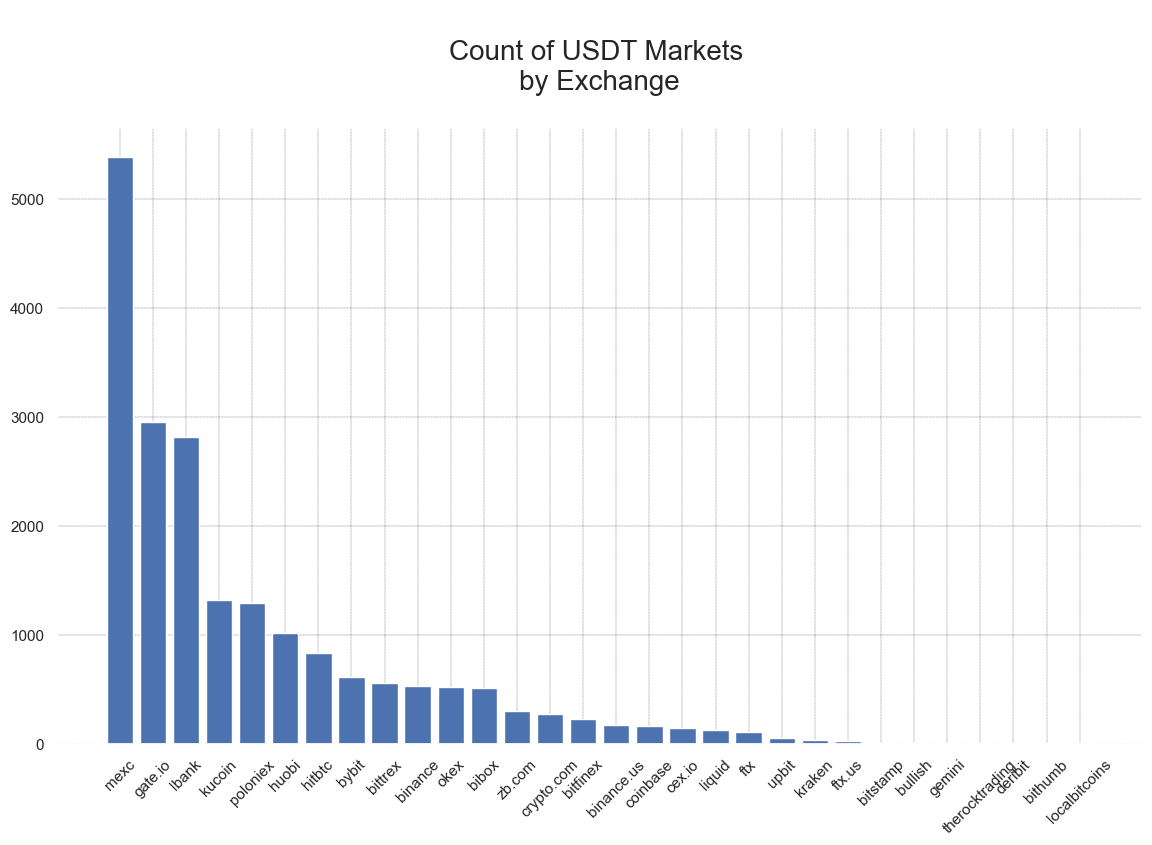

In [12]:
fig, ax1 = plt.subplots()
ax1.bar(x=markets_by_exchange['exchange'], height=markets_by_exchange['count'], width=0.8)
plt.setp(ax1.get_xticklabels(), rotation=45);
ax1.set_facecolor("white")
plt.grid(color = 'black', linestyle = '--', linewidth = 0.2)
plt.title('\nCount of '+ str(ticker).upper() + ' Markets \nby Exchange\n',fontdict={'fontsize':20,'font':'arial'});

# Get stablecoin prices

### Single market trades
Trades are one of the foundational data types we collect from exchanges. From raw trades data, we can construct additional aggregated metrics.

In [13]:
market = 'coinbase-usdt-usd-spot'
coinbase_trades = client.get_market_trades(
    markets = market,
    limit_per_market = 100,
    paging_from = 'end'
).to_dataframe()
coinbase_trades

,market,time,coin_metrics_id,amount,price,database_time,side
0,coinbase-usdt-usd-spot,2024-10-03 16:37:50.356121+00:00,109485916,3000.0,0.99985,2024-10-03 16:37:51.099860+00:00,buy
1,coinbase-usdt-usd-spot,2024-10-03 16:37:52.857847+00:00,109485917,3000.0,0.99985,2024-10-03 16:37:53.278230+00:00,buy
2,coinbase-usdt-usd-spot,2024-10-03 16:37:54.748770+00:00,109485918,1555.08,0.99985,2024-10-03 16:37:55.566500+00:00,buy
3,coinbase-usdt-usd-spot,2024-10-03 16:37:55.358549+00:00,109485919,3000.0,0.99985,2024-10-03 16:37:55.652974+00:00,buy
4,coinbase-usdt-usd-spot,2024-10-03 16:37:59.787414+00:00,109485920,2069.41,0.99985,2024-10-03 16:38:00.856793+00:00,buy
...,...,...,...,...,...,...,...
95,coinbase-usdt-usd-spot,2024-10-03 16:41:24.050200+00:00,109486011,19.56,0.99985,2024-10-03 16:41:24.700790+00:00,buy
96,coinbase-usdt-usd-spot,2024-10-03 16:41:24.746299+00:00,109486012,1170.67,0.99985,2024-10-03 16:41:25.211754+00:00,buy
97,coinbase-usdt-usd-spot,2024-10-03 16:41:26.109516+00:00,109486013,7.18,0.99985,2024-10-03 16:41:26.660344+00:00,buy
98,coinbase-usdt-usd-spot,2024-10-03 16:41:26.855646+00:00,109486014,3000.0,0.99984,2024-10-03 16:41:27.752326+00:00,sell


### Single market candles

From raw trades data, we construct OHLC candles for each market. Candles include the following data types:

* **price_open:**   The opening price of the candle.
* **price_high:**  The high price of the candle.
* **price_low:**  The low price of the candle.
* **price_close:** The close price of the candle.
* **vwap:**  The volume-weighted average price of the candle.
* **volume:** The volume of the candle in units of the base asset.
* **candle_usd_volume:** The volume of the candle in units of U.S. dollars. 
* **candle_trades_count:** The number of trades in the candle interval. 

In [14]:
market = 'coinbase-usdt-usd-spot'
coinbase_candles = client.get_market_candles(
    markets = market,
    frequency = '1d'
).to_dataframe()

In [15]:
coinbase_candles

,market,time,price_open,price_close,price_high,price_low,vwap,volume,candle_usd_volume,candle_trades_count
0,coinbase-usdt-usd-spot,2021-05-04 00:00:00+00:00,1.002,1.0006,1.003,0.999,1.000696,24564061.73,24581147.409593,30527
1,coinbase-usdt-usd-spot,2021-05-05 00:00:00+00:00,1.0006,1.0013,1.002,0.9997,1.000816,40170830.16,40203590.541009,43688
2,coinbase-usdt-usd-spot,2021-05-06 00:00:00+00:00,1.0013,1.0009,1.002,1.0004,1.001023,51129166.79,51181449.603235,51177
3,coinbase-usdt-usd-spot,2021-05-07 00:00:00+00:00,1.0008,1.0011,1.0018,1.0,1.001045,44247619.59,44293836.840656,48729
4,coinbase-usdt-usd-spot,2021-05-08 00:00:00+00:00,1.001,1.0016,1.0022,1.0009,1.00147,26972741.16,27012382.918589,50140
...,...,...,...,...,...,...,...,...,...,...
1243,coinbase-usdt-usd-spot,2024-09-28 00:00:00+00:00,1.00012,1.00011,1.00021,1.0,1.000127,69876132.62,69884972.64875,33216
1244,coinbase-usdt-usd-spot,2024-09-29 00:00:00+00:00,1.00011,1.00013,1.00021,1.00001,1.000107,85000340.62,85009396.570012,34237
1245,coinbase-usdt-usd-spot,2024-09-30 00:00:00+00:00,1.00014,0.99971,1.00014,0.99958,0.999863,250585092.98,250550678.3691,81461
1246,coinbase-usdt-usd-spot,2024-10-01 00:00:00+00:00,0.9997,0.99975,0.99991,0.99923,0.999677,460273457.69,460124819.483157,169777


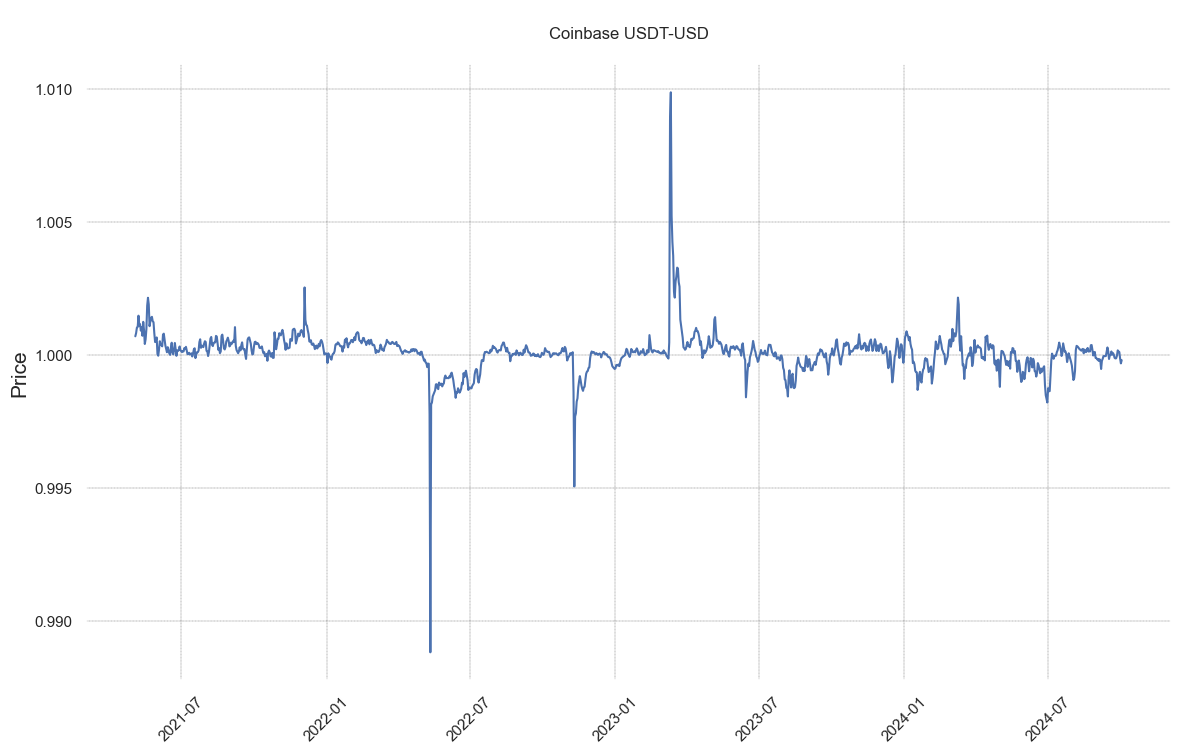

In [16]:
ax1 = plt.subplot()
coinbase_price = sns.lineplot(data=coinbase_candles,y=coinbase_candles.vwap,x=coinbase_candles.time)
plt.setp(ax1.get_xticklabels(), rotation=45);
ax1.set_facecolor("white")
plt.grid(color = 'black', linestyle = '--', linewidth = 0.2)
coinbase_price.set_xlabel("", fontsize = 15)
coinbase_price.set_ylabel("Price", fontsize = 15)
coinbase_price.set_title('\nCoinbase USDT-USD\n', fontsize = 18, font = 'arial');

### Reference Rate Candles

We offer reference rates quoted in USD, Euro, Bitcoin, and Ethereum. We now support these quote currencies for our entire reference rates coverage universe of over 500 assets and for all of our frequencies, including 1s, 1m, 1h, 1d-ny-close and 1d.

Current composition of markets for USDT-USD Reference Rate pair (as of May 17, 2023):

- "coinbase-usdt-usd-spot",
- "coinbase-eth-usdt-spot",
- "coinbase-btc-usdt-spot",
- "kraken-usdt-usd-spot",
- "binance-btc-usdt-spot",
- "binance-eth-usdt-spot",
- "crypto.com-usdt-usd-spot"


In [17]:
pairs = client.catalog_asset_pair_candles().to_dataframe()

2024-10-03 11:41:41 WARNING  /catalog/ endpoints will be deprecated in the future. Consider using /catalog-v2/ and /reference-data/ endpoints instead.


In [18]:
pairs.loc[pairs['pair']=='usdt-usd']

,pair,frequency,min_time,max_time
8640,usdt-usd,1m,2013-12-28 00:00:00+00:00,2024-10-03 16:39:00+00:00
8641,usdt-usd,5m,2013-12-28 00:00:00+00:00,2024-10-03 16:35:00+00:00
8642,usdt-usd,10m,2013-12-28 00:00:00+00:00,2024-10-03 16:30:00+00:00
8643,usdt-usd,15m,2013-12-28 00:00:00+00:00,2024-10-03 16:15:00+00:00
8644,usdt-usd,30m,2013-12-28 00:00:00+00:00,2024-10-03 16:00:00+00:00
8645,usdt-usd,1h,2013-12-28 00:00:00+00:00,2024-10-03 15:00:00+00:00
8646,usdt-usd,4h,2013-12-28 00:00:00+00:00,2024-10-03 12:00:00+00:00
8647,usdt-usd,1d,2013-12-28 00:00:00+00:00,2024-10-02 00:00:00+00:00


In [19]:
pair_candles = client.get_pair_candles(
    pairs='usdt-usd',
    start_time =  datetime.now() - timedelta(weeks=4),
    frequency='1d'
).to_dataframe()

In [20]:
pair_candles.tail()

,pair,time,price_open,price_close,price_high,price_low
22,usdt-usd,2024-09-28 00:00:00+00:00,1.00016,1.000153,1.00053,0.999861
23,usdt-usd,2024-09-29 00:00:00+00:00,1.000116,1.00013,1.000492,0.999772
24,usdt-usd,2024-09-30 00:00:00+00:00,1.00013,0.999649,1.00053,0.99937
25,usdt-usd,2024-10-01 00:00:00+00:00,0.999639,0.9998,1.000897,0.998931
26,usdt-usd,2024-10-02 00:00:00+00:00,0.9998,0.99982,1.000601,0.999219


In [21]:
prices = pair_candles[['price_open','price_close','price_high','price_low','time']].set_index('time')

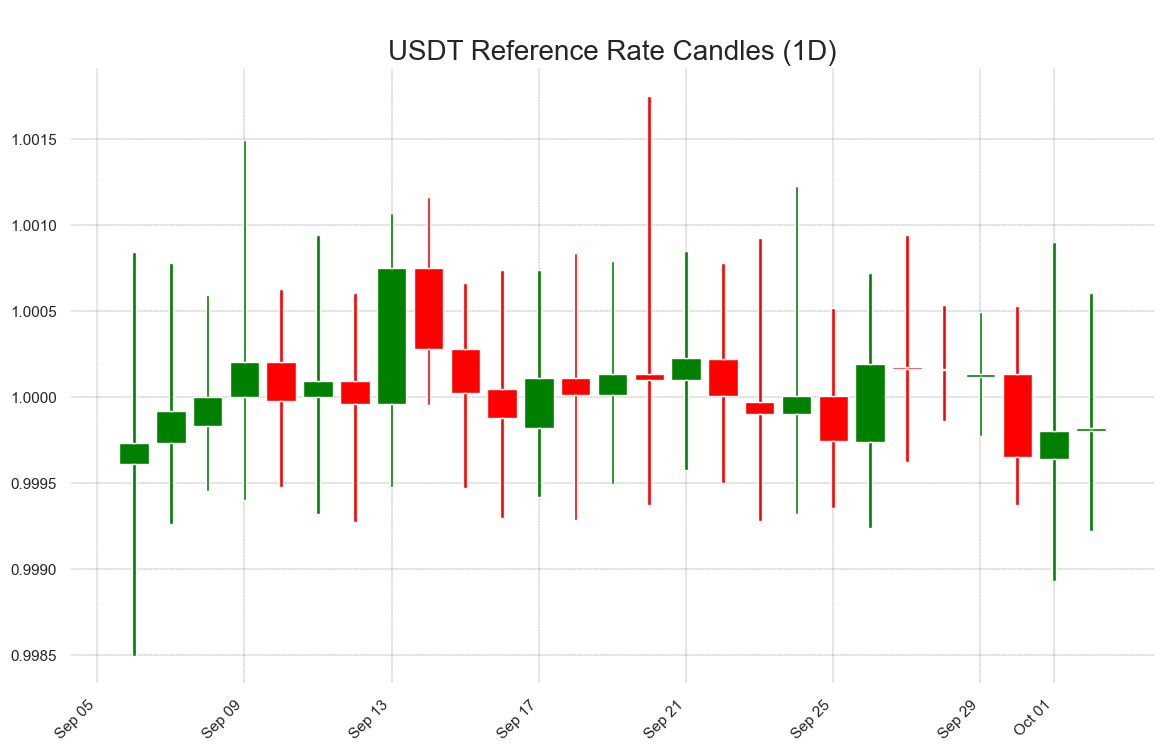

In [22]:
fig, ax = plt.subplots()
ax.ticklabel_format(useOffset=False)
width = 0.8
width2 = .1
ax.set_facecolor("white")
plt.grid(color = 'black', linestyle = '--', linewidth = 0.2)
plt.title('\n'+ str(ticker).upper() + ' Reference Rate Candles (1D)',fontdict={'fontsize':20,'font':'arial'});

up = prices[prices.price_close>=prices.price_open]
down = prices[prices.price_close<prices.price_open]
col1 = 'green'
col2 = 'red'

#plot prices
ax.bar(up.index,up.price_close-up.price_open,width,bottom=up.price_open,color=col1)
ax.bar(up.index,up.price_high-up.price_close,width2,bottom=up.price_close,color=col1)
ax.bar(up.index,up.price_low-up.price_open,width2,bottom=up.price_open,color=col1)
ax.bar(down.index,down.price_close-down.price_open,width,bottom=down.price_open,color=col2)
ax.bar(down.index,down.price_high-down.price_open,width2,bottom=down.price_open,color=col2)
ax.bar(down.index,down.price_low-down.price_close,width2,bottom=down.price_close,color=col2)

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')
ax.xaxis.set_minor_locator(MonthLocator(bymonthday=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.show()

### Reference Rate 

In [23]:
rr_catalog = client.catalog_asset_metrics_v2(assets='usdt', metrics='ReferenceRateUSD').to_dataframe()

In [24]:
rr_catalog

,asset,metrics
0,usdt,"[{'metric': 'ReferenceRateUSD', 'frequencies':..."


In [25]:
# rr_catalog[['asset','full_name','metric','frequency','min_time','max_time']]

In [26]:
asset_rr = client.get_asset_metrics(
    assets = 'usdt',
    metrics = 'ReferenceRateUSD',
    frequency = '1m',
    start_time =  datetime.now() - timedelta(hours=24)
).to_dataframe()

In [27]:
asset_rr

,asset,time,ReferenceRateUSD
0,usdt,2024-10-02 11:42:00+00:00,0.99984
1,usdt,2024-10-02 11:43:00+00:00,0.99979
2,usdt,2024-10-02 11:44:00+00:00,0.99983
3,usdt,2024-10-02 11:45:00+00:00,0.999845
4,usdt,2024-10-02 11:46:00+00:00,0.99982
...,...,...,...
1735,usdt,2024-10-03 16:37:00+00:00,0.999861
1736,usdt,2024-10-03 16:38:00+00:00,0.99985
1737,usdt,2024-10-03 16:39:00+00:00,0.99985
1738,usdt,2024-10-03 16:40:00+00:00,0.99984


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or var

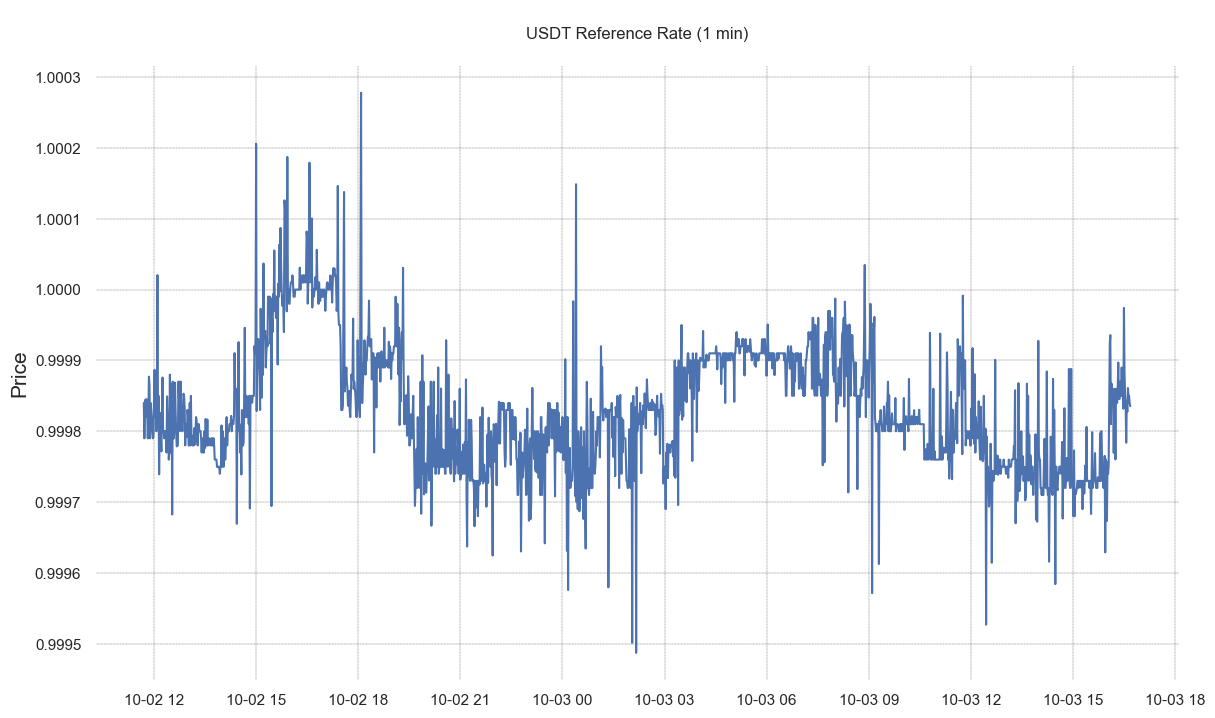

In [28]:
ax1 = plt.subplot()
ax1.ticklabel_format(useOffset=False)
asset_rr_chart = sns.lineplot(data=asset_rr,y=asset_rr.ReferenceRateUSD,x=asset_rr.time)
plt.setp(ax1.get_xticklabels());
ax1.set_facecolor("white")
plt.grid(color = 'black', linestyle = '--', linewidth = 0.2)
asset_rr_chart.set_xlabel("", fontsize = 15)
asset_rr_chart.set_ylabel("Price", fontsize = 15)
asset_rr_chart.set_title('\nUSDT Reference Rate (1 min)\n', fontsize = 18, font = 'arial');

## Principal Market Price

The Principal Market Prices identify a principal market for each asset and utilize the most recent price from this market. Common use cases are for fair value measurement, preparing financial statements, and calculating closing prices for indexes or financial benchmarks.

In [29]:
asset_pmp = client.get_asset_metrics(
    assets = 'usdt',
    metrics = ['principal_market_price_usd','principal_market_usd'],
    frequency = '1m',
    start_time =  datetime.now() - timedelta(hours=24)
).to_dataframe()

In [30]:
asset_pmp

,asset,time,principal_market_price_usd,principal_market_usd
0,usdt,2024-10-02 11:42:00+00:00,0.999835,binance-btc-usdt-spot
1,usdt,2024-10-02 11:43:00+00:00,0.999921,binance-btc-usdt-spot
2,usdt,2024-10-02 11:44:00+00:00,0.999892,binance-btc-usdt-spot
3,usdt,2024-10-02 11:45:00+00:00,0.999845,binance-btc-usdt-spot
4,usdt,2024-10-02 11:46:00+00:00,0.999763,binance-btc-usdt-spot
...,...,...,...,...
1735,usdt,2024-10-03 16:37:00+00:00,0.999861,crypto.com-btc-usdt-spot
1736,usdt,2024-10-03 16:38:00+00:00,0.999839,crypto.com-btc-usdt-spot
1737,usdt,2024-10-03 16:39:00+00:00,0.999777,crypto.com-btc-usdt-spot
1738,usdt,2024-10-03 16:40:00+00:00,0.999679,crypto.com-btc-usdt-spot


In [31]:
market_list = list(set(asset_pmp['principal_market_usd'].to_list()))
market_list

['crypto.com-eth-usdt-spot',
 'binance-eth-usdt-spot',
 'binance-btc-usdt-spot',
 'crypto.com-btc-usdt-spot']

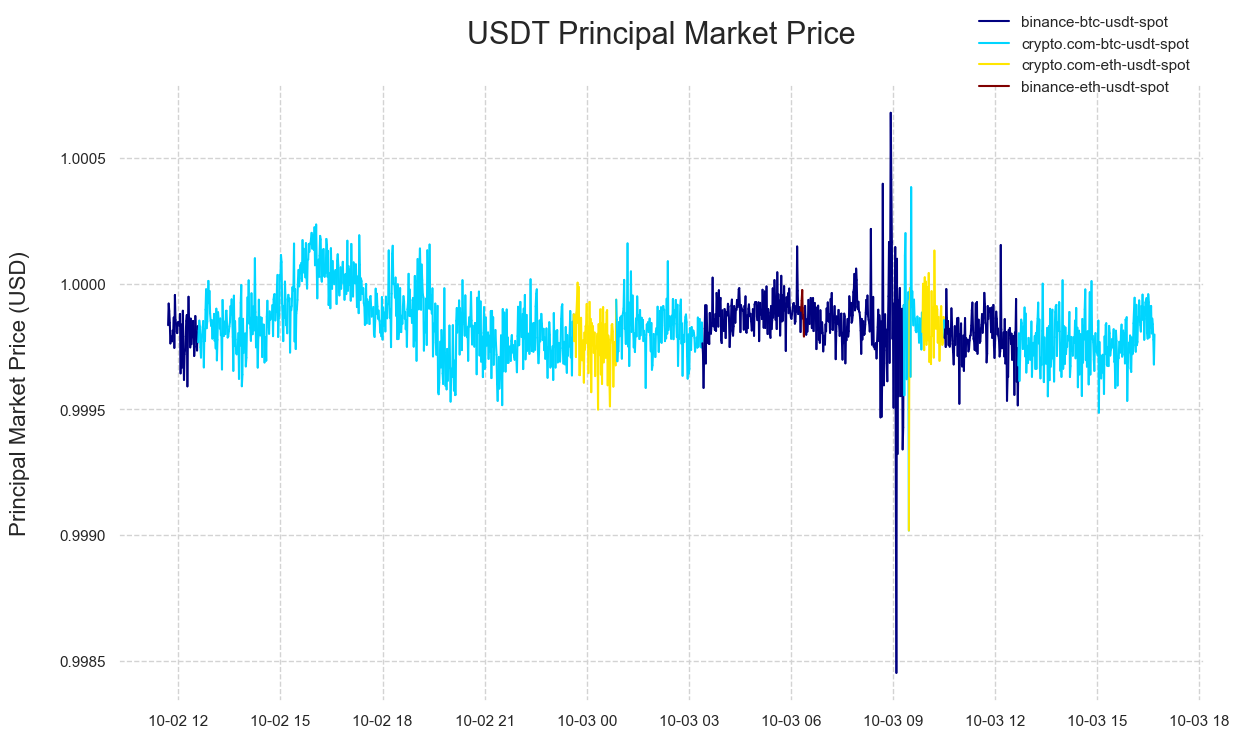

In [32]:
unique_markets = asset_pmp['principal_market_usd'].unique()
colors = plt.cm.jet(np.linspace(0,1,len(unique_markets)))
color_map = dict(zip(unique_markets, colors))

asset_pmp = asset_pmp.sort_values('time')
fig, ax = plt.subplots()
ax.set_facecolor("white")
ax.grid(color='lightgray', linestyle='--')

for i in range(1, len(asset_pmp)):
    ax.plot(asset_pmp['time'].iloc[i-1:i+1], 
            asset_pmp['principal_market_price_usd'].iloc[i-1:i+1], 
            color=color_map[asset_pmp['principal_market_usd'].iloc[i]], 
            label=asset_pmp['principal_market_usd'].iloc[i])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
import matplotlib.ticker as ticker

ax.legend(by_label.values(), by_label.keys(), loc='upper right', frameon=False, bbox_to_anchor=(1, 1.135))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(float(x), '.4f')))

plt.title('USDT Principal Market Price\n', fontsize=22)
plt.xlabel('')
plt.ylabel('Principal Market Price (USD)\n',fontsize=16)
plt.show()